In [160]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import importlib

import pre_processing

In [162]:
auction_data_path = "../Data/data_files/df_PRL_SRL_TRL_bids.parquet"
mfrr_activation_price_path = "../Data/data_files/df_TRE_Tertiary_Control_Energy_bids.parquet"
dayahead_price_path = "../Data/data_files/df_dayahead_randomized.parquet"
imbalance_price_path = "../Data/data_files/df_imbalance_penalty_oneprice.parquet"
imbalance_volume_path = "../Data/data_files/df_imbalance_volume_ch.parquet"

auction_data = pd.read_parquet(auction_data_path)
mfrr_activation_price = pd.read_parquet(mfrr_activation_price_path)
dayahead_price = pd.read_parquet(dayahead_price_path).reset_index()
dayahead_price['time'] = pd.to_datetime(dayahead_price['time'], utc=True)
imbalance_price = pd.read_parquet(imbalance_price_path)
imbalance_volume = pd.read_parquet(imbalance_volume_path)
imbalance_data = pd.merge(imbalance_volume, imbalance_price, on='time', how='inner').reset_index()
imbalance_data['time'] = pd.to_datetime(imbalance_data['time'], utc=True)

In [218]:
def test(time, time_utc):
    volume = imbalance_data.loc[imbalance_data['time'] == pd.to_datetime(time_utc), 'imbalance_volume_ch'].values[0]

    # apply uniform disturbance to volume of 85MW
    np.random.seed(42)  # For reproducibility
    disturbance = np.random.uniform(-40, 40)  # Random disturbance between -40 and 40
    volume_adj = volume + disturbance

    aFRR_data, mFFR_weekly_data, mFFR_daily_data = get_bid_profiles(auction_data, time, volume_adj)
    mFRR_data = get_mFFR_profile(mFFR_weekly_data, mFFR_daily_data)

    wap_aFRR = compute_WAP(0.95*volume_adj, aFRR_data)
    wap_mFRR = 2 * compute_WAP(0.05 * 0.5 * volume_adj, mFRR_data)

    spot_price = get_spot_price(dayahead_price, pd.to_datetime(time_utc).floor('h'))
    imbalance_penalty = compute_imbalance_price(volume_adj, wap_mfrr=wap_mFRR, wap_afrr=wap_aFRR, spot=spot_price)
    imbalance_price_pred = imbalance_penalty
    imbalance_price_act = imbalance_data.loc[imbalance_data['time'] == pd.to_datetime(time_utc), 'price_imbalance_penalty'].values[0]

    return volume, volume_adj, imbalance_price_pred, imbalance_price_act

In [220]:
importlib.reload(pre_processing)
from pre_processing import *

months = [10]

res = {month: np.zeros((24*4, 4)) for month in months}
# 2023-10-15
for month in months:
    for i in range(24*4):
        time_utc = pd.to_datetime(f"2023-{month}-15", utc=True) + pd.Timedelta(minutes=15*i)
        time = parse_utc_to_time_info(time_utc)
        volume, volume_adj, imbalance_price_pred, imbalance_price_act = test(time,time_utc)

        res[month][i] = (volume, volume_adj, imbalance_price_pred, imbalance_price_act)

[-1.13925794  2.41721154  2.51585899  3.01402613 -1.30273785 -1.20854118
 -2.59648152  3.58180266  1.42208224  1.31463479  0.78301642  0.74366602
  0.70146076  0.9993221   1.29739496 -0.72767678 -0.27991687 -1.7988843
 -0.81339332 -1.39026965  1.85060362  3.43443613  1.45946134  1.76960782
  0.89560846 -2.38015308 -2.60856678 -2.6835318  -2.81313048 -2.82516257
 -2.59455    -1.15       -2.76       -3.98       -1.82       -1.72058865
 -5.1        -4.64       -1.51        0.46       -6.4        -6.96
 -0.88        8.86       -0.6        -0.9         9.96601707 10.7628769
 12.49727172  8.32       14.53        7.03040383 -1.16031523 -1.97
 -1.32       -3.15        2.54600064  2.25248689 -3.53       -4.12
  6.31729023 -0.89121567 -3.77       -6.61       -1.72226218 -3.47
 -5.7        -8.79       -5.47       -3.34       -2.03       -1.30403775
 -5.49       -4.8         7.52       -1.489018   -7.96       -8.2
 -1.39039536 -0.06149485 -7.72        9.48       -0.46350803  0.46895097
 -5.62     

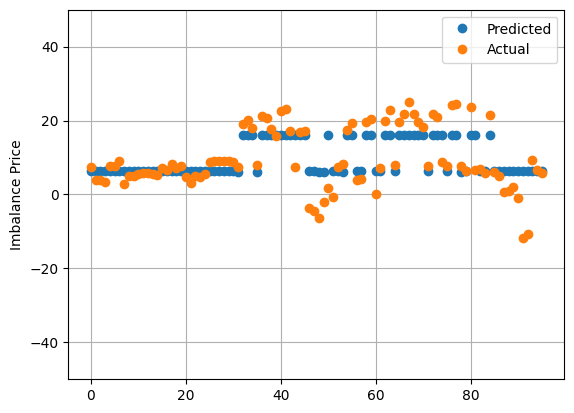

In [223]:
for month in months:
    output = res[month]
    pd.DataFrame(output).to_csv(f'result_{month}.csv', index=False)

    # compute root mean square error using numpy package
    temp = (output[:,2] - output[:,3])
    print(temp)
    rmse = np.sqrt(np.mean(temp**2))
    mae = np.mean(np.abs(temp))
    print(f'MAE for month {month}: {mae}')
    print(f'RMSE for month {month}: {rmse}')

    fig = plt.figure()
    plt.plot([x[2] for x in res[month]], 'o', label='Predicted')
    plt.plot([x[3] for x in res[month]], 'o', label='Actual')
    # plt.xlabel('Imbalance Volume')
    plt.ylabel('Imbalance Price')
    plt.ylim(-50, 50)
    plt.legend()
    plt.grid(True)
    plt.show()

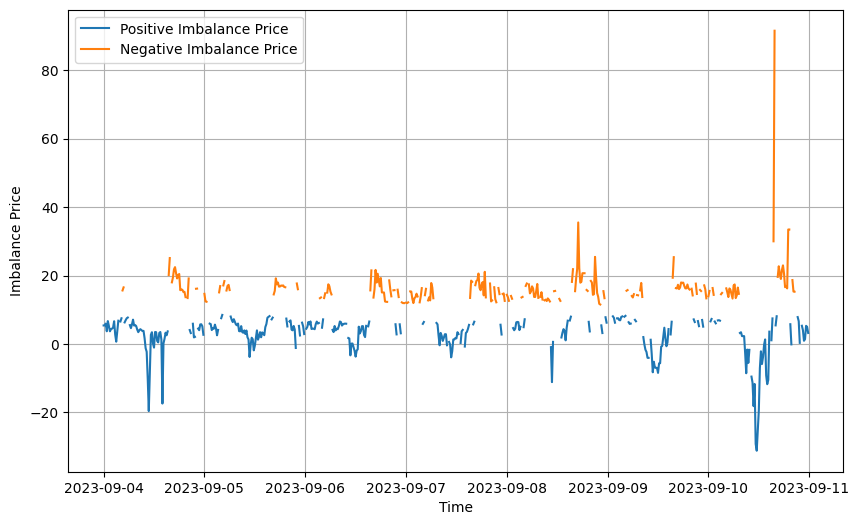

In [207]:
year = 2023
week = 36

data = imbalance_data[(imbalance_data['time'].dt.isocalendar().year == year) & (imbalance_data['time'].dt.isocalendar().week == week)].reset_index()

time = data['time']
imbalance_data_plus = data.where(data['imbalance_volume_ch'] > 0)
imbalance_data_minus = data.where(data['imbalance_volume_ch'] < 0)

#  * imbalance_data_plus['imbalance_volume_ch']

plt.figure(figsize=(10,6))
plt.plot(time, imbalance_data_plus['price_imbalance_penalty'], label='Positive Imbalance Price')
plt.plot(time, imbalance_data_minus['price_imbalance_penalty'], label='Negative Imbalance Price')

plt.grid(True)
plt.xlabel('Time')
plt.ylabel('Imbalance Price')
plt.legend()
plt.show()